# The loss function (loghazard) has issues, so we need to look into that.

**For now it might be good to use pytorch.loss**, which implements partial log liklihood and Weibull losses. 

---

### **Context: Why Breslow’s Method?**

In the Cox model, the **partial likelihood** is used to estimate the regression coefficients without specifying the baseline hazard function. However, when **ties** occur — that is, **multiple events happen at the same time point** — the original Cox partial likelihood (which assumes distinct event times) becomes problematic.

This is where **Breslow’s method** comes in: it provides a way to **approximate the partial likelihood** in the presence of tied event times.

---

### **Breslow’s Approximation: The Idea**

Suppose at time \( t_j \), **\( d_j \) individuals** experience the event (i.e., a tie). Let:

- \( R_j \): the **risk set** just before time \( t_j \)
- \( \beta \): the vector of regression coefficients
- \( x_i \): covariate vector for individual \( i \)

The **exact partial likelihood** for tied events is computationally intensive. Breslow proposed a simpler approximation:

\[
L_B(\beta) = \prod_{j} \frac{\exp\left( \sum_{i \in D_j} \beta^T x_i \right)}{\left[ \sum_{i \in R_j} \exp(\beta^T x_i) \right]^{d_j}}
\]

Where:
- \( D_j \): the set of individuals who fail at time \( t_j \)
- The denominator is raised to the power \( d_j \), treating the tied events as if they occurred **sequentially but with the same risk set**.

---

### **Interpretation**

- **Numerator**: Product of exponentiated linear predictors for those who failed at \( t_j \)
- **Denominator**: Risk set sum raised to the number of events — this is the **approximation** part

This method **underestimates the denominator** slightly compared to the exact method, especially when the number of ties is large.

---

### **Comparison with Other Methods**

| Method         | Accuracy with Ties | Computational Cost | Notes |
|----------------|--------------------|--------------------|-------|
| **Breslow**    | Low (for many ties) | Low                | Simple, fast |
| **Efron**      | Higher              | Moderate           | Better approximation |
| **Exact**      | Highest             | High               | Computationally expensive |

---

### **When to Use Breslow’s Method**

- **Few ties**: Breslow is often sufficient and computationally efficient.
- **Many ties**: Prefer **Efron’s method** or **exact partial likelihood**.

---



In [1]:
import torchsurv.loss.cox as tscox #import neg_partial_log_likelihood

# Own implementation (super simple, double check!). Assumes events are ordered already.

def naive_partial_likelihood(log_hazard, event_indicator, event_time):
    risk_set = torch.flip(torch.cumsum(torch.flip(torch.exp(log_hazard), [0]), dim=0), [0])
    partial_likelihood = torch.sum(log_hazard[event_indicator == 1] - torch.log(risk_set[event_indicator == 1]))
    return partial_likelihood

def breslow_partial_likelihood(log_hazard, event_indicator, event_time):
    unique_times, counts = torch.unique(event_time[event_indicator == 1], return_counts=True)
    print(unique_times, counts)
    partial_likelihood = 0
    for t, d in zip(unique_times, counts):
        risk_set = torch.sum(torch.exp(log_hazard[event_time >= t]))
        partial_likelihood += torch.sum(log_hazard[(event_time == t) & (event_indicator == 1)]) - d * torch.log(risk_set)
        print(t, d, risk_set)
    return partial_likelihood

def efron_partial_likelihood(log_hazard, event_indicator, event_time):
    unique_times, counts = torch.unique(event_time[event_indicator == 1], return_counts=True)
    partial_likelihood = 0
    for t, d in zip(unique_times, counts):
        risk_set = torch.sum(torch.exp(log_hazard[event_time >= t]))
        tied_hazard_sum = torch.sum(torch.exp(log_hazard[(event_time == t) & (event_indicator == 1)]))
        for k in range(d):
            partial_likelihood += (torch.sum(log_hazard[(event_time == t) & (event_indicator == 1)]) - torch.log(risk_set - k * tied_hazard_sum / d))
    return partial_likelihood

# Example usage
log_hazard = torch.tensor([0.5, 1.0, 1.0, 1.5, 2.0])
event_indicator = torch.tensor([1, 1, 0, 1, 1])
event_time = torch.tensor([1, 2, 2, 2, 3])

log_hazard = torch.tensor([0.5, 1.0, 1.5, 2.0])
event_indicator = torch.tensor([1, 1, 1, 1])
event_time = torch.tensor([1, 2, 2, 3])

reduction = 'mean' # or 'sum', depending on your needs
torchsurv_ll_breslow = tscox.neg_partial_log_likelihood(log_hazard, event_indicator, event_time, ties_method='breslow', reduction = reduction)
torchsurv_ll_efron = tscox.neg_partial_log_likelihood(log_hazard, event_indicator, event_time, ties_method='efron', reduction = reduction)
partial_ll_naive = naive_partial_likelihood(log_hazard, event_indicator, event_time)
partial_ll_breslow = breslow_partial_likelihood(log_hazard, event_indicator, event_time)
partial_ll_efron = efron_partial_likelihood(log_hazard, event_indicator, event_time)

print("---")
print("TorchSurv Breslow Partial Likelihood:", torchsurv_ll_breslow.item())
print("TorchSurv Efron Partial Likelihood:  ", torchsurv_ll_efron.item())
print("---")
print("Naive Partial Likelihood:  ", partial_ll_naive.item())
print("Breslow Partial Likelihood:", partial_ll_breslow.item())
print("Efron Partial Likelihood:  ", partial_ll_efron.item())

NameError: name 'torch' is not defined

---

# Survival Analysis with TorchSurv and Artificial Data

This notebook demonstrates:
1. Generating artificial survival data
2. Training a TorchSurv LogHazard model
3. Evaluating and visualizing the results using stratification plots

In [2]:
# Set environment variable to handle OpenMP runtime conflict
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Also set this for the current session
if os.name == 'nt':  # Windows
    try:
        import ctypes
        ctypes.CDLL('mkl_rt.dll')
    except:
        pass

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Import required libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchsurv.loss.cox as tscox

# Import ukko survival functions
from ukko.survival import generate_survival_data_LL, plot_KM

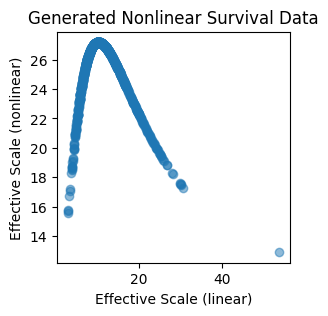

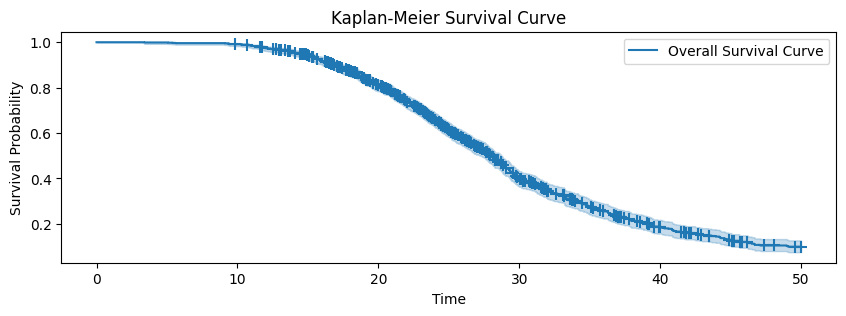


Data shape: (1000, 6)
Number of events: 677
Censoring rate: 0.32299999999999995


In [4]:
import importlib
import ukko.survival
importlib.reload(ukko.survival)

def generate_data(n_samples=1000, n_features=3, n_informative=1, 
                 shape=5, scale=10.0, censoring=0.3, random_seed=42, 
                 nonlinear = True):
    """Generate synthetic survival data with log-logistic distribution."""
    np.random.seed(random_seed)
    
    survival_data, true_coefficients = ukko.survival.generate_survival_data_LL(
        n_samples, n_features, n_informative,
        shape, scale, censoring,
        nonlinear = nonlinear
    )
    feature_cols = [col for col in survival_data.columns if col.startswith('feature_')]
    
    return survival_data, true_coefficients, feature_cols

def prepare_data_for_pytorch(survival_data, feature_cols):
    """Prepare survival data for PyTorch."""
    # Prepare data for PyTorch
    X = torch.FloatTensor(survival_data[feature_cols].values)
    times = torch.FloatTensor(survival_data['observed_time'].values)
    events = torch.FloatTensor(survival_data['event_observed'].values)
    # Create data loader
    dataset = TensorDataset(X, times, events)
    batch_size = X.shape[0]  # Use the entire dataset as one batch
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return train_loader


# Generate linear data:
survival_data_lin, true_coefficients_lin, feature_cols_lin = \
  generate_data(nonlinear=False)
train_loader_lin = prepare_data_for_pytorch(survival_data_lin, feature_cols_lin)

# Generate nonlinear data:
survival_data_nonlin, true_coefficients_nonlin, feature_cols_nonlin = \
  generate_data(nonlinear=True)
train_loader_nonlin = prepare_data_for_pytorch(survival_data_nonlin, feature_cols_nonlin)
plt.title("Generated Nonlinear Survival Data")

# Plot initial KM curve for the entire dataset
plot_KM(survival_data_nonlin)

print("\nData shape:", survival_data_nonlin.shape)
print("Number of events:", survival_data_nonlin['event_observed'].sum())
print("Censoring rate:", 1 - survival_data_nonlin['event_observed'].mean())

### Helper functions

In [5]:
def stratify_and_plot(survival_data, risk_scores, n_groups=4, model_name=''):
    """Stratify patients into multiple risk groups and plot KM curves."""
    survival_data = survival_data.copy()
    survival_data['predicted_risk'] = risk_scores
    
    # Calculate quantile cutoffs
    quantiles = np.linspace(0, 1, n_groups + 1)
    cutoffs = np.quantile(survival_data['predicted_risk'], quantiles)
    
    # Plot KM curves
    plt.figure(figsize=(12, 8))
    
    # Create color map for groups
    try:
        colors = plt.cm.managua(np.linspace(0, 1, n_groups))
    except:
        colors = plt.cm.viridis(np.linspace(0, 1, n_groups))
    
    for i in range(n_groups):
        if i == 0:
            mask = survival_data['predicted_risk'] <= cutoffs[1]
            group_label = f'Lowest Risk (Q1)'
        elif i == n_groups - 1:
            mask = survival_data['predicted_risk'] > cutoffs[-2]
            group_label = f'Highest Risk (Q{n_groups})'
        else:
            mask = (survival_data['predicted_risk'] > cutoffs[i]) & \
                   (survival_data['predicted_risk'] <= cutoffs[i+1])
            group_label = f'Q{i+1}'
        
        group = survival_data[mask]
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=group['observed_time'],
                event_observed=group['event_observed'],
                label=group_label)
        kmf.plot_survival_function(show_censors=True, ci_show=False, color=colors[i])
        
        print(f"{group_label} size: {len(group)}")
    
    plt.title(f'Kaplan-Meier Survival Curves by Risk Group ({model_name})')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return cutoffs

def plot_training_loss(result):
  model, history, best_loss = result
  # Plot training loss
  plt.figure(figsize=(10, 6))
  plt.plot(history['train_loss'])
  plt.axhline(y=best_loss, color='r', linestyle='--', label='Best Loss')
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

## Define models

In [6]:
# Define the LogHazard model
class LogHazardModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Define ukko loghazard model for 1-timepoint data using dual attention mechanism
from ukko.core import DualAttentionRegressor1
class UkkoLogHazardModel(nn.Module):
    """A PyTorch model for survival analysis using a dual attention mechanism."""
    def __init__(self, n_features):
        super().__init__()
        self.attention_net = DualAttentionRegressor1(
            n_features=n_features,
            time_steps=1,  # Since we're using instantaneous inputs
            d_model=64,
            n_heads=4,
            dropout=0.1,
            n_modules=3
        )
    
    def forward(self, x):
        # Add time dimension expected by DualAttentionRegressor
        x = x.unsqueeze(2)  # [batch_size, n_features, 1]
        
        # Get predictions from attention network
        predictions, feat_weights, time_weights = self.attention_net(x)
        
        return predictions, feat_weights, time_weights

## Compare linear and ukko loghazard models

### Linear data

Training Linear Model...
Epoch 10/500, Loss: 5.8812, Best Loss: 5.8801
Epoch 20/500, Loss: 5.8401, Best Loss: 5.8401
Epoch 30/500, Loss: 5.7980, Best Loss: 5.7980
Epoch 40/500, Loss: 5.7549, Best Loss: 5.7549
Epoch 50/500, Loss: 5.7228, Best Loss: 5.7111
Epoch 60/500, Loss: 5.6746, Best Loss: 5.6746
Epoch 70/500, Loss: 5.6476, Best Loss: 5.6476
Epoch 80/500, Loss: 5.6151, Best Loss: 5.6118
Epoch 90/500, Loss: 5.5988, Best Loss: 5.5988
Epoch 100/500, Loss: 5.6050, Best Loss: 5.5848
Epoch 110/500, Loss: 5.6007, Best Loss: 5.5848
Epoch 120/500, Loss: 5.5995, Best Loss: 5.5793
Epoch 130/500, Loss: 5.6045, Best Loss: 5.5748
Epoch 140/500, Loss: 5.5956, Best Loss: 5.5744
Epoch 150/500, Loss: 5.5838, Best Loss: 5.5744
Epoch 160/500, Loss: 5.6051, Best Loss: 5.5744
Epoch 170/500, Loss: 5.5939, Best Loss: 5.5744
Epoch 180/500, Loss: 5.6010, Best Loss: 5.5744
Epoch 190/500, Loss: 5.5949, Best Loss: 5.5744
Epoch 200/500, Loss: 5.5756, Best Loss: 5.5739
Epoch 210/500, Loss: 5.5846, Best Loss: 5.57

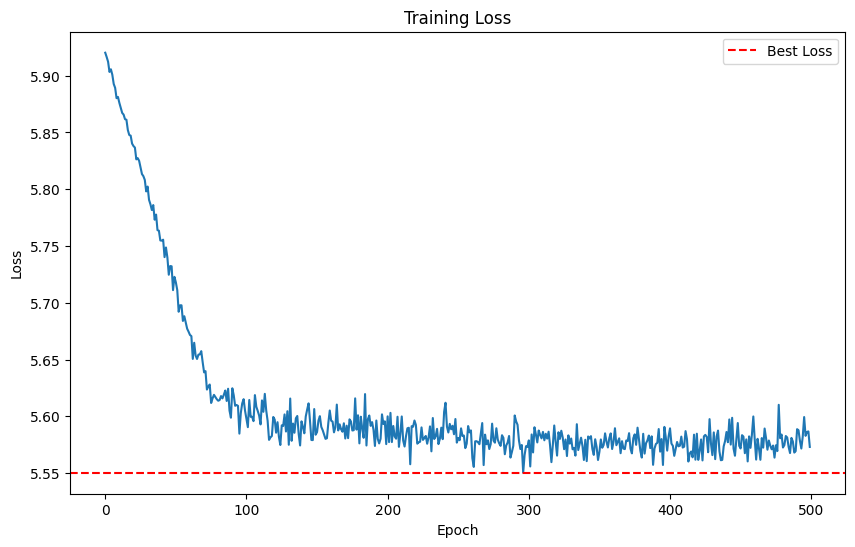

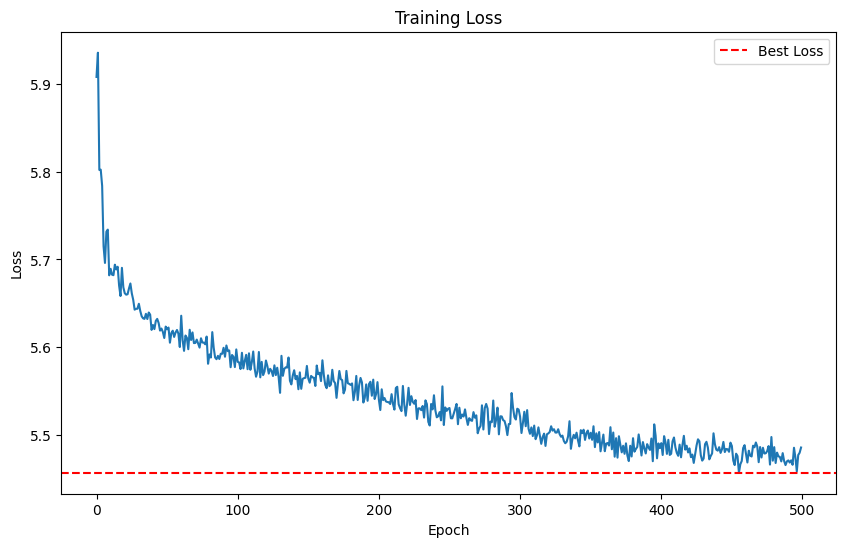

In [47]:
n_epochs = 500

import importlib
import ukko.core
from ukko.core import train_model_simple
#from ukko.core import UkkoLogHazardModel, train_model_simple
importlib.reload(ukko.core)

# Linear Model:
model_lin = LogHazardModel(len(feature_cols_lin))
optimizer_lin = torch.optim.Adam(model_lin.parameters(), lr=0.001)
reduction = 'mean'

# Ukko LogHazard Model:
model = UkkoLogHazardModel(len(feature_cols_lin))
#model = ukko.core.UkkoLogHazardModel(len(feature_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
reduction = 'mean'

# Train the linear model
print("Training Linear Model...")
#model, history, best_loss = train_model_simple(
result_lin = train_model_simple(
    model_lin, 
    train_loader_lin, 
    optimizer_lin,
    n_epochs=n_epochs,
    device='cuda',
    reduction=reduction
)

print("Training Ukko LogHazard Model...")
# Train the linear model
result_ukko = train_model_simple(
    model, 
    train_loader_lin, 
    optimizer,
    n_epochs=n_epochs,
    device='cuda',
    reduction=reduction
)
print(" ")

plot_training_loss(result_lin)
plot_training_loss(result_ukko)

Lowest Risk (Q1) size: 200
Q2 size: 200
Q3 size: 200
Q4 size: 200
Highest Risk (Q5) size: 200


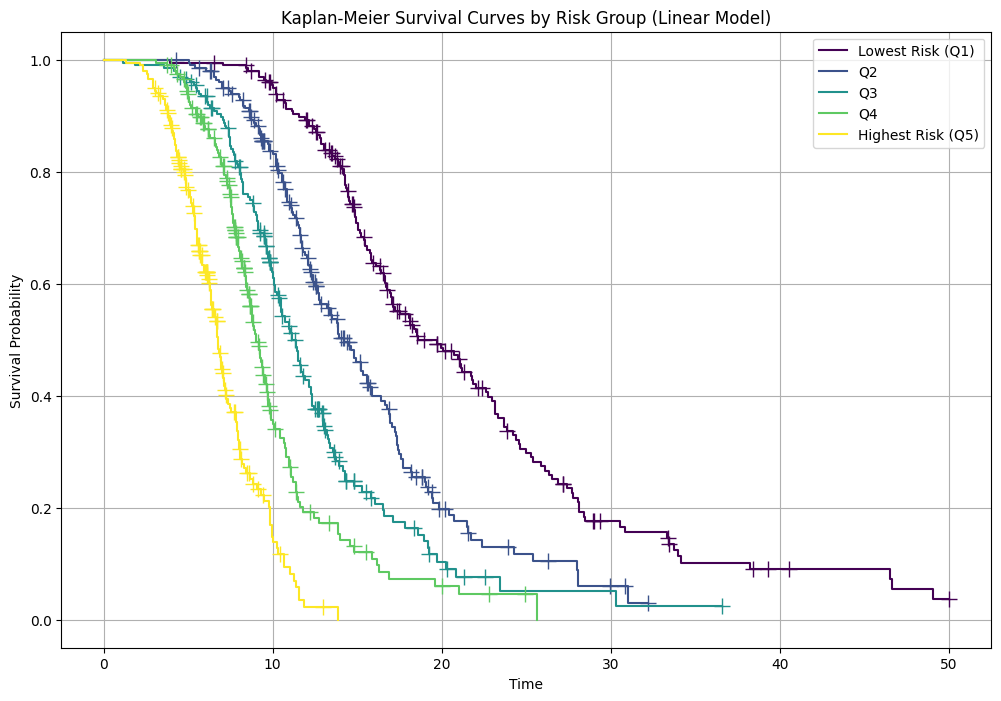

Lowest Risk (Q1) size: 200
Q2 size: 200
Q3 size: 200
Q4 size: 200
Highest Risk (Q5) size: 200


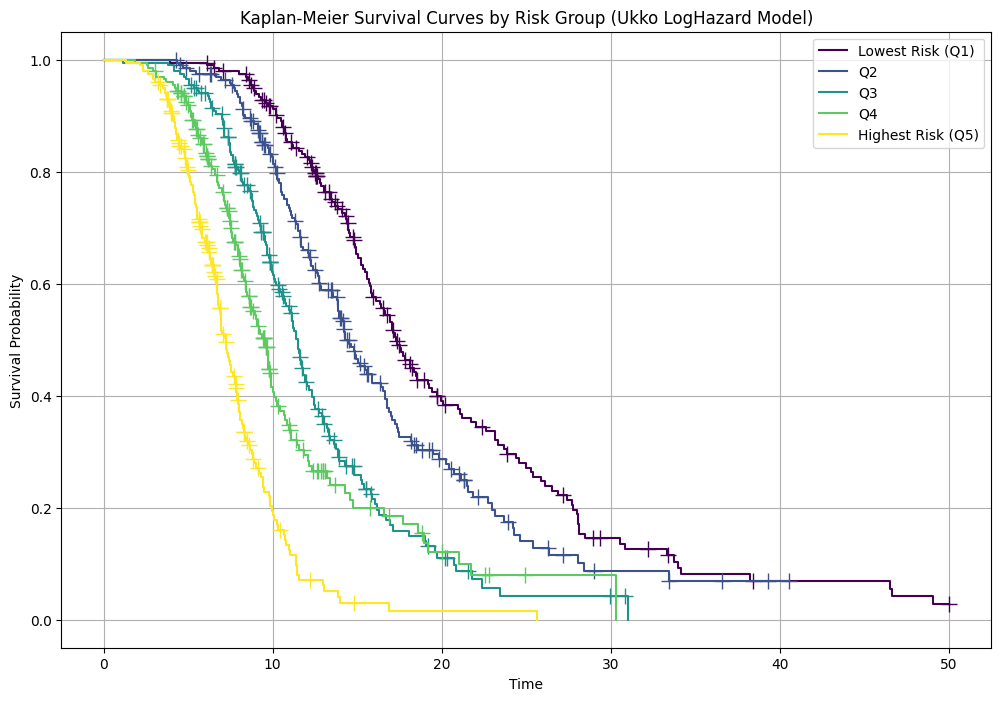

In [40]:
# Linear Model performance evaluation:
X =  train_loader_lin.dataset.tensors[0].cpu()

# Generate risk scores using the trained linear model
model_lin.eval().to('cpu')
with torch.no_grad():
    risk_scores_lin = model_lin(X).numpy().flatten()
# Create stratification plot
cutoffs_lin = stratify_and_plot(survival_data_lin, risk_scores_lin, n_groups=5,
                            model_name='Linear Model')

# Ukko Model performance evaluation:
# Generate risk scores using the trained ukko model
model.eval().cpu()
with torch.no_grad():
    risk_scores, feat_weights, time_weights = model(X)
    risk_scores = risk_scores.numpy()
# Create stratification plot
cutoffs = stratify_and_plot(survival_data_lin, risk_scores, n_groups=5, 
                            model_name='Ukko LogHazard Model')

### Non-linear data 

In [45]:
importlib.reload(ukko.core)

<module 'ukko.core' from '/users/ericfey1/github/ukko/src/ukko/core.py'>

Training Linear Model...


/users/ericfey1/.local/lib/python3.11/site-packages/torchsurv/loss/cox.py:138: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(


Epoch 3/200, Loss: 6.0346, Best Loss: 6.0301
Epoch 6/200, Loss: 6.0250, Best Loss: 6.0250
Epoch 9/200, Loss: 6.0268, Best Loss: 6.0250
Epoch 12/200, Loss: 6.0264, Best Loss: 6.0235
Epoch 15/200, Loss: 6.0252, Best Loss: 6.0235
Epoch 18/200, Loss: 6.0230, Best Loss: 6.0230
Epoch 21/200, Loss: 6.0239, Best Loss: 6.0217
Epoch 24/200, Loss: 6.0207, Best Loss: 6.0196
Epoch 27/200, Loss: 6.0223, Best Loss: 6.0181
Epoch 30/200, Loss: 6.0206, Best Loss: 6.0181
Epoch 33/200, Loss: 6.0147, Best Loss: 6.0147
Epoch 36/200, Loss: 6.0157, Best Loss: 6.0143
Epoch 39/200, Loss: 6.0157, Best Loss: 6.0141
Epoch 42/200, Loss: 6.0190, Best Loss: 6.0129
Epoch 45/200, Loss: 6.0084, Best Loss: 6.0072
Epoch 48/200, Loss: 6.0131, Best Loss: 6.0068
Epoch 51/200, Loss: 6.0038, Best Loss: 6.0038
Epoch 54/200, Loss: 6.0116, Best Loss: 6.0008
Epoch 57/200, Loss: 6.0064, Best Loss: 6.0008
Epoch 60/200, Loss: 6.0010, Best Loss: 5.9989
Epoch 63/200, Loss: 5.9964, Best Loss: 5.9964
Epoch 66/200, Loss: 6.0012, Best Loss

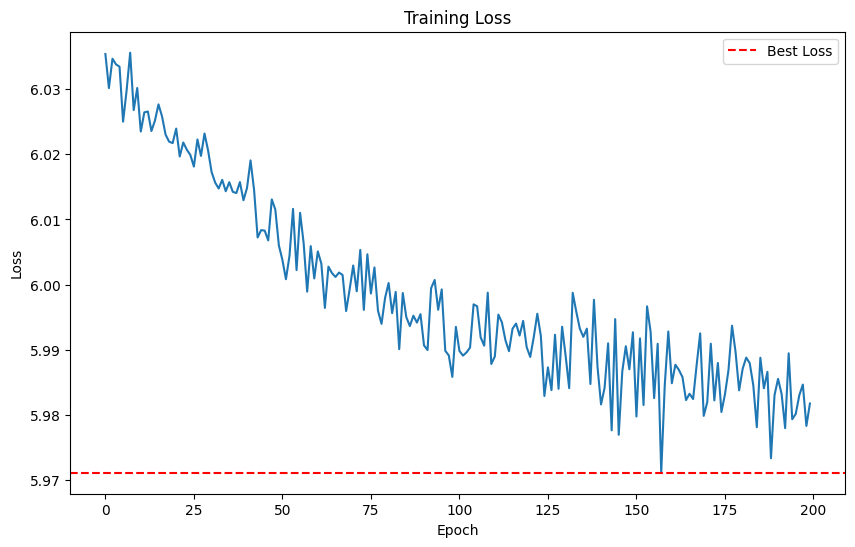

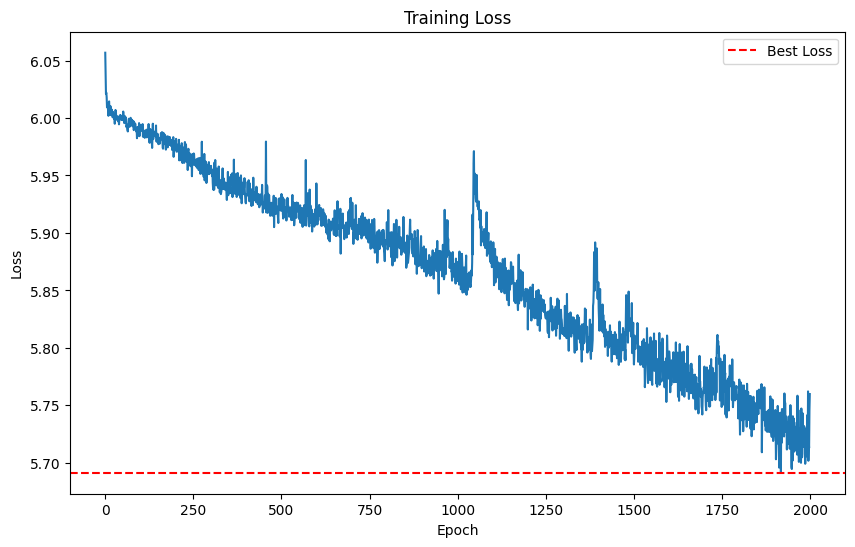

Lowest Risk (Q1) size: 200
Q2 size: 200
Q3 size: 200
Q4 size: 200
Highest Risk (Q5) size: 200


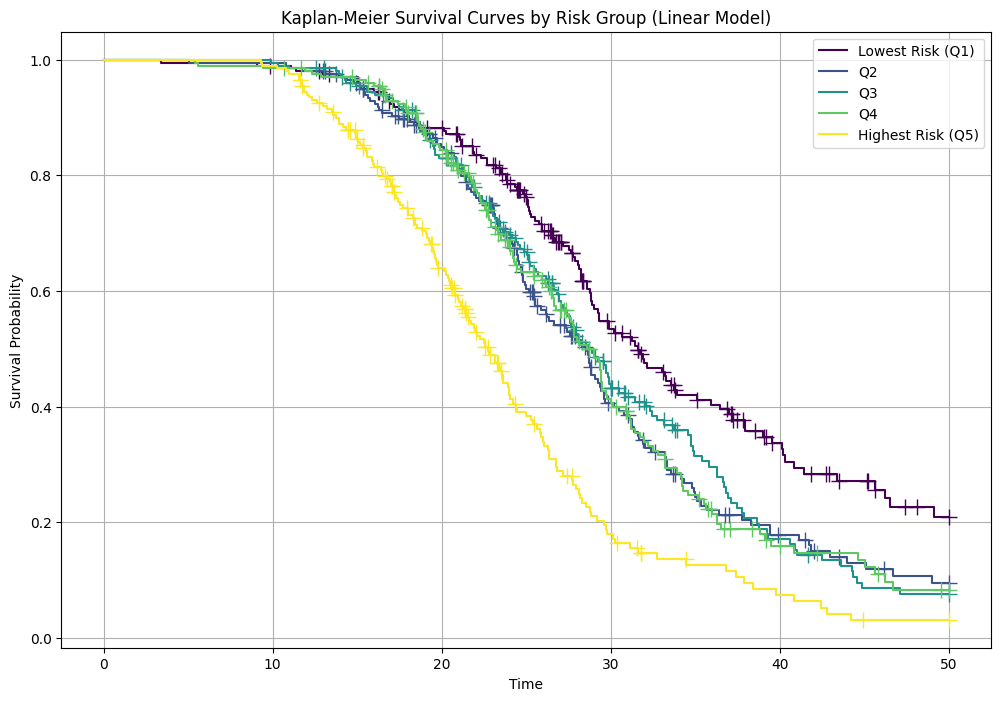

Lowest Risk (Q1) size: 200
Q2 size: 200
Q3 size: 200
Q4 size: 200
Highest Risk (Q5) size: 200


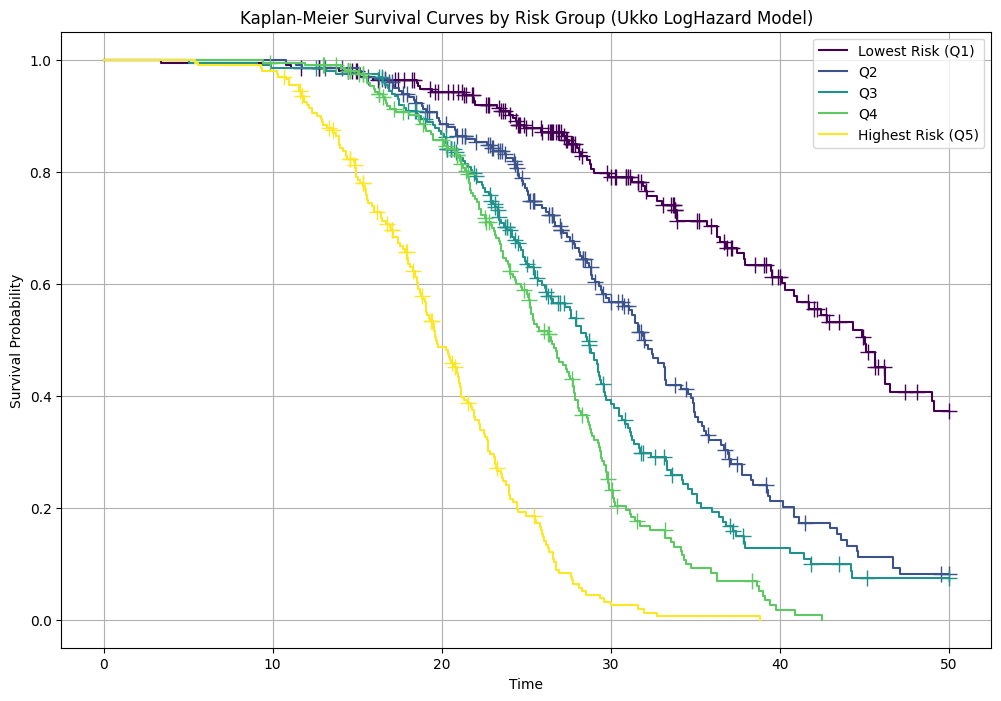

In [41]:
n_epochs = 2000

# Linear Model:
model_lin = LogHazardModel(len(feature_cols_nonlin))
optimizer_lin = torch.optim.Adam(model_lin.parameters(), lr=0.001)
reduction = 'mean'

# Ukko LogHazard Model:
model = UkkoLogHazardModel(len(feature_cols_nonlin))
#model = ukko.core.UkkoLogHazardModel(len(feature_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
reduction = 'mean'

# Train the linear model
print("Training Linear Model...")
#model, history, best_loss = train_model_simple(
result_lin = train_model_simple(
    model_lin, 
    train_loader_nonlin, 
    optimizer_lin,
    n_epochs=n_epochs // 10,
    device='cuda',
    reduction=reduction
)

print("Training Ukko LogHazard Model...")
# Train the ukko model
result_ukko = train_model_simple(
    model, 
    train_loader_nonlin, 
    optimizer,
    n_epochs=n_epochs,
    device='gpu',
    reduction=reduction
)
print(" ")

plot_training_loss(result_lin)
plot_training_loss(result_ukko)

# Linear Model performance evaluation:
X =  train_loader_nonlin.dataset.tensors[0].cpu()

# Generate risk scores using the trained model
model_lin.eval().to('cpu')
with torch.no_grad():
    risk_scores_lin = model_lin(X).numpy().flatten()
# Create stratification plot
cutoffs_lin = stratify_and_plot(survival_data_nonlin, risk_scores_lin, n_groups=5,
                            model_name='Linear Model')

# Ukko Model performance evaluation:
# Generate risk scores using the trained model
model.eval().to('cpu')
with torch.no_grad():
    risk_scores, feat_weights, time_weights = model(X)
    risk_scores = risk_scores.numpy()

# Create stratification plot
cutoffs = stratify_and_plot(survival_data_nonlin, risk_scores, n_groups=5, 
                            model_name='Ukko LogHazard Model')

## 1. Simple loghazard model

In [ ]:
# Prepare data for PyTorch
X = torch.FloatTensor(survival_data[feature_cols].values)
times = torch.FloatTensor(survival_data['observed_time'].values)
events = torch.FloatTensor(survival_data['event_observed'].values)

# Create data loader
dataset = TensorDataset(X, times, events)
batch_size = X.shape[0]  # Use the entire dataset as one batch
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = LogHazardModel(len(feature_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

C:\Users\ericf\Github\torchsurv\src\torchsurv\loss\cox.py:138: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(


Epoch 10/100, Loss: 6.0253
Epoch 20/100, Loss: 6.0249
Epoch 30/100, Loss: 6.0269
Epoch 40/100, Loss: 6.0189
Epoch 50/100, Loss: 6.0194
Epoch 60/100, Loss: 6.0118
Epoch 70/100, Loss: 6.0070
Epoch 80/100, Loss: 6.0087
Epoch 90/100, Loss: 5.9958
Epoch 100/100, Loss: 5.9904


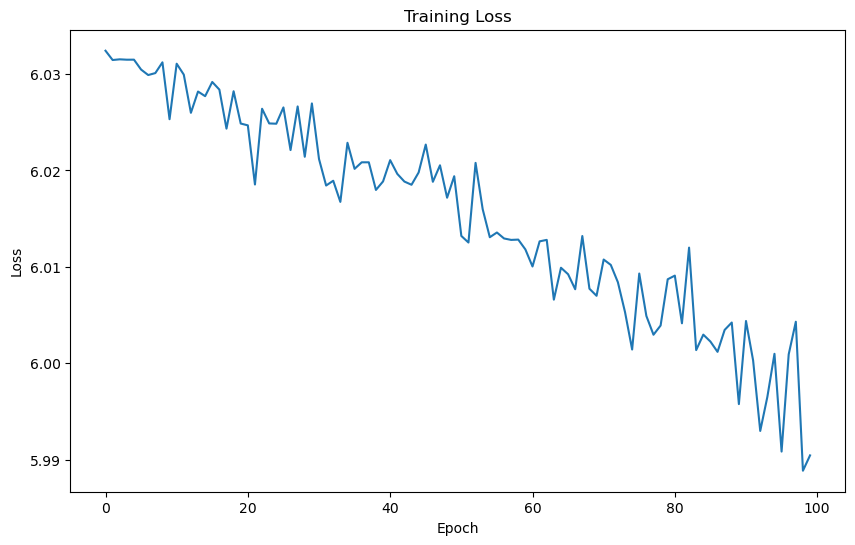

In [118]:
# Training loop
def train_epoch(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    
    for X_batch, times_batch, events_batch in train_loader:
        optimizer.zero_grad()
        
        # Get log hazards
        log_hazards = model(X_batch)
        
        # Calculate loss
        loss = tscox.neg_partial_log_likelihood(log_hazards, events_batch==1, times_batch, ties_method='efron', reduction = reduction)
        
        # # Basic implementation of cox partial likelihood
        # log_risk = log_hazards
        # risk = torch.exp(log_risk)
        
        # # Sort by time
        # sorted_times, sort_idx = torch.sort(times_batch, descending=True)
        # risk = risk[sort_idx]
        # events = events_batch[sort_idx]
        
        # # Calculate loss using cox partial likelihood
        # log_cumsum = torch.log(torch.cumsum(risk, dim=0) + 1e-8)
        # loss = -torch.mean((log_risk[events == 1] - log_cumsum[events == 1]))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Train the model
n_epochs = 100
losses = []

for epoch in range(n_epochs):
    loss = train_epoch(model, train_loader, optimizer)
    losses.append(loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 2. Ukko model

## 2. Ukko Model

Now we'll train a DualAttentionRegressor model from the ukko package and compare its performance.

In [ ]:
import importlib
import ukko.core
#from ukko.core import UkkoLogHazardModel, train_model_simple
importlib.reload(ukko.core)

# Example usage (replace existing training loop):
model = LogHazardModel(len(feature_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
reduction = 'mean'

# Usage: UkkoLogHazardModel:
model = ukko.core.UkkoLogHazardModel(len(feature_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
reduction = 'mean'

# Train the model
model, history, best_loss = train_model_simple(
    model, train_loader, optimizer,
    n_epochs=10,
    device='gpu',
    reduction=reduction
)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'])
plt.axhline(y=best_loss, color='r', linestyle='--', label='Best Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model performance evaluation:
# Generate risk scores using the trained model
model.eval()
with torch.no_grad():
    risk_scores, feat_weights, time_weights = model(X)
    risk_scores = risk_scores.numpy()

# Create stratification plot
cutoffs = stratify_and_plot(survival_data, risk_scores, n_groups=5)



NameError: name 'LogHazardModel' is not defined

Lowest Risk (Q1) size: 200
Q2 size: 200
Q3 size: 200
Q4 size: 200
Highest Risk (Q5) size: 200


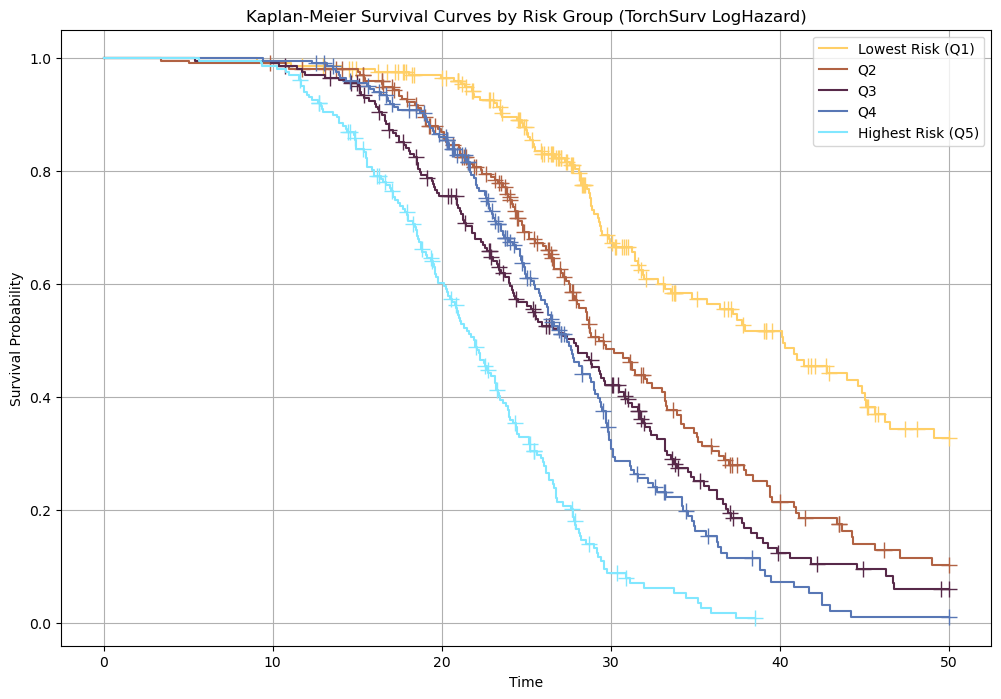

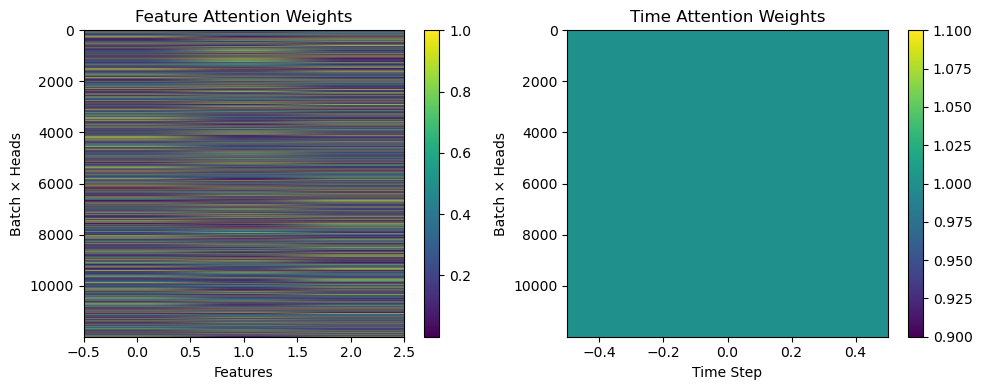

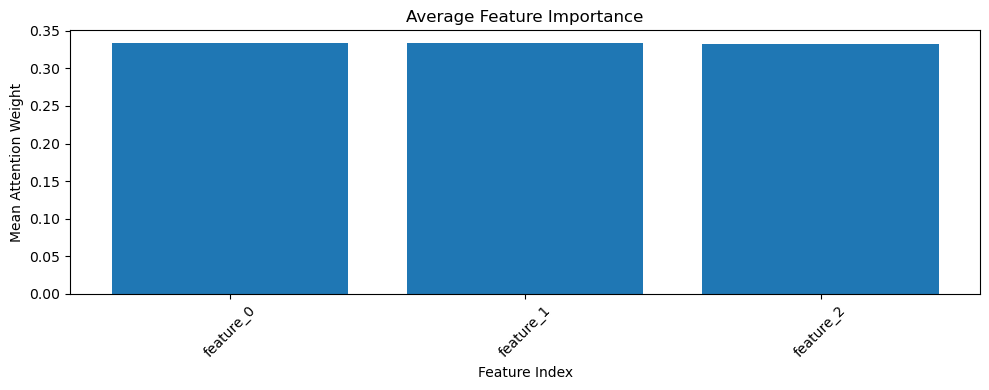

In [124]:
# Generate risk scores using the trained model
model.eval()
with torch.no_grad():
    risk_scores, feat_weights, time_weights = model(X)
    risk_scores = risk_scores.numpy()

# Create stratification plot
cutoffs = stratify_and_plot(survival_data, risk_scores, n_groups=5)

# Visualize attention weights
plt.figure(figsize=(10, 4))

# Feature attention weights - reshape for visualization
feat_attention = feat_weights.detach().numpy()
feat_attention = feat_attention.reshape(-1, len(feature_cols))  # Reshape to [batch*heads, n_features]

plt.subplot(121)
plt.imshow(feat_attention, aspect='auto')
plt.title('Feature Attention Weights')
plt.colorbar()
plt.xlabel('Features')
plt.ylabel('Batch × Heads')

# Time attention weights - should be 1×1 for our case
plt.subplot(122)
time_attention = time_weights.detach().numpy()
time_attention = time_attention.reshape(-1, 1)  # Reshape to [batch*heads, 1]

plt.imshow(time_attention, aspect='auto')
plt.title('Time Attention Weights')
plt.colorbar()
plt.xlabel('Time Step')
plt.ylabel('Batch × Heads')

plt.tight_layout()
plt.show()

# Print average feature attention weights
mean_attention = feat_attention.mean(axis=0)
plt.figure(figsize=(10, 4))
plt.bar(range(len(feature_cols)), mean_attention)
plt.title('Average Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Mean Attention Weight')
plt.xticks(range(len(feature_cols)), feature_cols, rotation=45)
plt.tight_layout()
plt.show()

# Appendix - depreciated stuff

C:\Users\ericf\Github\torchsurv\src\torchsurv\loss\cox.py:138: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(


Epoch 3/600, Loss: 6.0313, Best Loss: 6.0313
Epoch 6/600, Loss: 6.0276, Best Loss: 6.0276
Epoch 9/600, Loss: 6.0274, Best Loss: 6.0274
Epoch 12/600, Loss: 6.0265, Best Loss: 6.0265
Epoch 15/600, Loss: 6.0244, Best Loss: 6.0244
Epoch 18/600, Loss: 6.0270, Best Loss: 6.0244
Epoch 21/600, Loss: 6.0246, Best Loss: 6.0240
Epoch 24/600, Loss: 6.0227, Best Loss: 6.0227
Epoch 27/600, Loss: 6.0209, Best Loss: 6.0209
Epoch 30/600, Loss: 6.0267, Best Loss: 6.0209
Epoch 33/600, Loss: 6.0316, Best Loss: 6.0201
Epoch 36/600, Loss: 6.0201, Best Loss: 6.0201
Epoch 39/600, Loss: 6.0237, Best Loss: 6.0171
Epoch 42/600, Loss: 6.0218, Best Loss: 6.0171
Epoch 45/600, Loss: 6.0201, Best Loss: 6.0171
Epoch 48/600, Loss: 6.0198, Best Loss: 6.0171
Epoch 51/600, Loss: 6.0211, Best Loss: 6.0163
Epoch 54/600, Loss: 6.0193, Best Loss: 6.0163
Epoch 57/600, Loss: 6.0225, Best Loss: 6.0163
Epoch 60/600, Loss: 6.0170, Best Loss: 6.0143
Epoch 63/600, Loss: 6.0198, Best Loss: 6.0143
Epoch 66/600, Loss: 6.0165, Best Loss

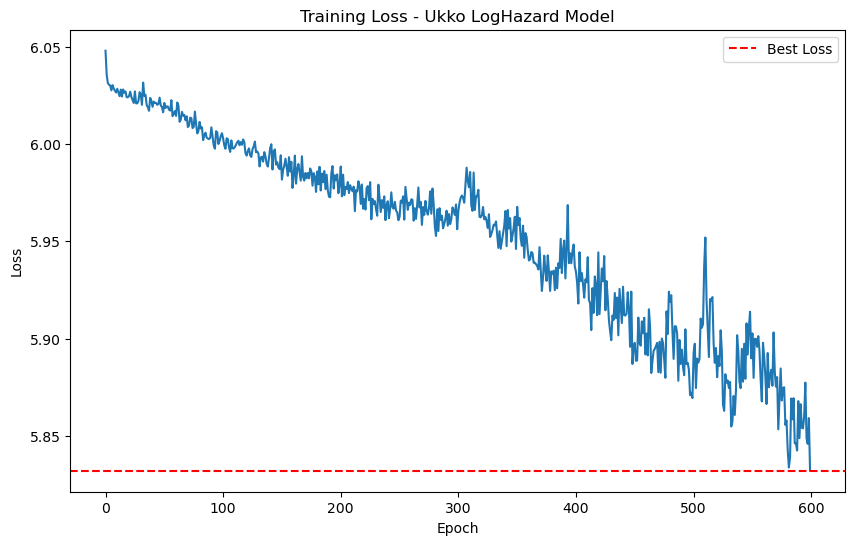


Loading best model with loss: 5.83213472366333


<All keys matched successfully>

In [123]:
from ukko.core import DualAttentionRegressor1
import copy 


# Define the Ukko LogHazard model
class UkkoLogHazardModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.attention_net = DualAttentionRegressor1(
            n_features=n_features,
            time_steps=1,  # Since we're using instantaneous inputs
            d_model=64,
            n_heads=4,
            dropout=0.1,
            n_modules=3
        )
    
    def forward(self, x):
        # Add time dimension expected by DualAttentionRegressor
        x = x.unsqueeze(2)  # [batch_size, n_features, 1]
        
        # Get predictions from attention network
        predictions, feat_weights, time_weights = self.attention_net(x)
        
        return predictions, feat_weights, time_weights

# Initialize model and optimizer
model = UkkoLogHazardModel(len(feature_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

# Training loop
n_epochs = 600  # Increased epochs since we're tracking best model
losses = []
best_loss = float('inf')
best_model_state = None

for epoch in range(n_epochs):
    # Adjust learning rate after 300 epochs
    if epoch == 300:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001

    model.train()
    total_loss = 0
    
    for X_batch, times_batch, events_batch in train_loader:
        optimizer.zero_grad()
        
        # Get log hazards
        log_hazards, feat_weights, time_weights = model(X_batch)
        
        # Calculate loss using TorchSurv's Cox partial likelihood
        loss = tscox.neg_partial_log_likelihood(log_hazards, events_batch==1, times_batch, ties_method='efron', reduction='mean')
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = copy.deepcopy(model.state_dict())
    
    if (epoch + 1) % 3 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}, Best Loss: {best_loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.axhline(y=best_loss, color='r', linestyle='--', label='Best Loss')
plt.title('Training Loss - Ukko LogHazard Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load best model for evaluation
print('\nLoading best model with loss:', best_loss)
model.load_state_dict(best_model_state)